In [67]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Define Signals

## Basic stuff

In [68]:
# sample period 
dt = 2e-9 # 2ns <-> 500 MHz

# number of samples
num_samples = 8192

# time
time = np.arange(0, 8192, 1) * dt

# signal power
power = 1

# small channel number
num_ch_small = 10

# large channel number
num_ch_large = 100

# noise_variance
noise_variance = 2e1

## Signal

In [69]:
# amplitude
amplitude = np.sqrt(power)

# frequency
freq = 25e6

signal = amplitude * np.exp(-1j * 2 * np.pi * freq * time) 


## Small Channel Number

In [76]:
signals_small = []

for n in range(num_ch_small):
    
    #noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
    #noise = noise[:, 0] + 1j * noise[:, 1]
    
    signals_small.append(signal * 1 / np.sqrt(num_ch_small))
    
signals_small = np.array(signals_small)

(signals_small.conjugate() * signals_small).sum(0).sum(0)


(8192+0j)

## Large Channel Number

In [73]:
signals_large = []

for n in range(num_ch_large):
    
    #noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
    #noise = noise[:, 0] + 1j * noise[:, 1]
    
    signals_large.append(signal * 1 / num_ch_large)
    
signals_large = np.array(signals_large)

abs(np.mean(np.sum(signals_large, axis = 0).conjugate() * np.sum(signals_large, axis = 0)))

1.0000000000000004

# Compare Signals

## Hypothetical array that collects the same power with different numbers of antennas. The amplitudes of signals in the array with more channels are smaller relative to the array with fewer antennas. e.g. An array with few high gain antennas or an array with many low gain antennas.

Total power from array with small channel number: 1.00
Total power from array with large channel number: 1.00


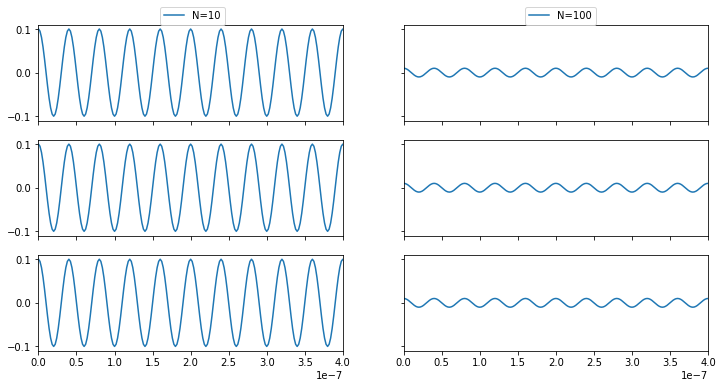

In [44]:
# power = <signal^H * signal>
pow_small = abs(np.mean(np.sum(signals_small, axis = 0).conjugate() * np.sum(signals_small, axis = 0)))
pow_large = abs(np.mean(np.sum(signals_large, axis = 0).conjugate() * np.sum(signals_large, axis = 0)))

print('Total power from array with small channel number: %.2f' % pow_small)
print('Total power from array with large channel number: %.2f' % pow_large)

fig, axs = plt.subplots(3, 2, figsize=(12,6), sharex=True, sharey=True)

for m in range(2):
    for n in range(3):
        if m == 0:
            axs[n, m].plot(time, np.real(signals_small[n, :]), label = 'N=10')
            
        else:
            axs[n, m].plot(time, np.real(signals_large[n, :]), label = 'N=100')
axs[0, 0].set_xlim(time[0], time[200])
axs[0, 0].legend(loc = (0.4,1))
axs[0, 1].legend(loc = (0.4,1))

## Add independent WGN to each channel. The array with many channels has lower SNR per channel.

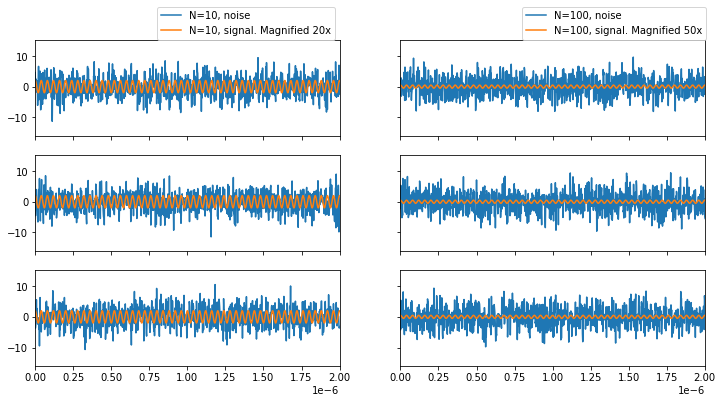

In [45]:
signals_small_noise = []
signals_large_noise = []

for n in range(signals_small.shape[0]):
    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
    noise = noise[:, 0] + 1j * noise[:, 1]
    
    signals_small_noise.append(signals_small[n, :] + noise)

signals_small_noise = np.array(signals_small_noise)
    
for n in range(signals_large.shape[0]):
    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
    noise = noise[:, 0] + 1j * noise[:, 1]
    
    signals_large_noise.append(signals_large[n, :] + noise)
    
signals_large_noise = np.array(signals_large_noise)
    
fig, axs = plt.subplots(3, 2, figsize=(12,6), sharex=True, sharey=True)

for m in range(2):
    for n in range(3):
        if m == 0:
            axs[n, m].plot(time, np.real(signals_small_noise[n, :]), label = 'N=10, noise')
            axs[n, m].plot(time, 20 * np.real(signals_small[n, :]), label = 'N=10, signal. Magnified 20x')
            
            
        else:
            axs[n, m].plot(time, np.real(signals_large_noise[n, :]), label = 'N=100, noise')
            axs[n, m].plot(time, 50 * np.real(signals_large[n, :]), label = 'N=100, signal. Magnified 50x')
            
axs[0, 0].set_xlim(time[0], time[1000])
#axs[0, 0].set_ylim(-1, 1)
axs[0, 0].legend(loc = (0.4,1))
axs[0, 1].legend(loc = (0.4,1))

# Standard Approach

## Sum signals and apply FFT. We observe that noise power scales as N. So the hypothetical array with more channels has worse SNR.

Text(0.5, 1.0, 'Large Channel Number')

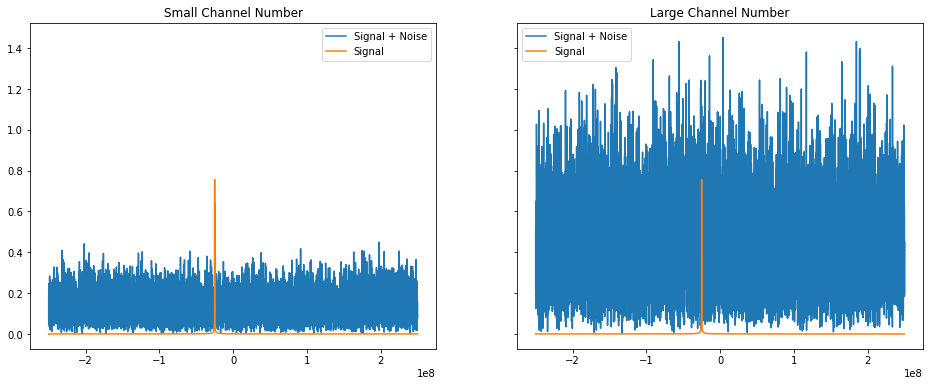

In [46]:
small_sum = signals_small.sum(0)
large_sum = signals_large.sum(0)

small_sum_noise = signals_small_noise.sum(0)
large_sum_noise = signals_large_noise.sum(0)

small_sum_noise_fft = np.fft.fftshift(np.fft.fft(small_sum_noise) / num_samples)
large_sum_noise_fft = np.fft.fftshift(np.fft.fft(large_sum_noise) / num_samples)

small_sum_fft = np.fft.fftshift(np.fft.fft(small_sum) / num_samples)
large_sum_fft = np.fft.fftshift(np.fft.fft(large_sum) / num_samples)
f = np.fft.fftshift(np.fft.fftfreq(num_samples, dt))

fig, axs = plt.subplots(1, 2, figsize=(16,6), sharey=True, sharex=True)

axs[0].plot(f, abs(small_sum_noise_fft), label='Signal + Noise')
axs[0].plot(f, abs(small_sum_fft), label = 'Signal')
axs[0].legend(loc=0)
axs[0].set_title('Small Channel Number')

axs[1].plot(f, abs(large_sum_noise_fft), label='Signal + Noise')
axs[1].plot(f, abs(large_sum_fft), label='Signal')
axs[1].legend(loc=0)
axs[1].set_title('Large Channel Number')

# Matched Filter Approach

## Compute the matched filter score

In [66]:
small_signal_vector = signals_small.reshape(signals_small.size)
large_signal_vector = signals_large.reshape(signals_large.size)

norm_small = 1 / np.sqrt(np.vdot(small_signal_vector, small_signal_vector) / noise_variance).real
norm_large = 1 / np.sqrt(np.vdot(large_signal_vector, large_signal_vector) / noise_variance).real

#norm_small = norm_small.reshape((norm_small.size, 1)).repeat(signals_small.shape[1], axis = 1)

#norm_large = 1 / np.sqrt((signals_large.conjugate() * signals_large).sum(1) / noise_variance)
#norm_large = norm_large.reshape((norm_large.size, 1)).repeat(signals_large.shape[1], axis = 1)

template_small = norm_small * small_signal_vector
template_large = norm_large * large_signal_vector
#print(norm_small)
#print(norm_large)

print(abs(np.vdot(small_signal_vector, template_small)), np.sqrt(10) * abs(np.vdot(large_signal_vector, template_large)))

127.9999999999996 128.00000000001188


In [ ]:
# reshape data
timeseries_small_noise = signals_small_noise.reshape(signals_small_noise.size)
timeseries_small = signals_small.reshape(signals_small.size)

timeseries_small_sum = signals_small.sum(0)
timeseries_small_noise_sum = signals_small_noise.sum(0)

timeseries_large_noise = signals_large_noise.reshape(signals_large_noise.size)
timeseries_large = signals_large.reshape(signals_large.size)

timeseries_large_sum = signals_large.sum(0)
timeseries_large_noise_sum = signals_large_noise.sum(0)

small_conv_noise = abs(scipy.signal.fftconvolve(timeseries_small, timeseries_small_noise))
large_conv_noise = abs(scipy.signal.fftconvolve(timeseries_large, timeseries_large_noise))

small_conv_noise_sum = abs(scipy.signal.fftconvolve(timeseries_small_sum, timeseries_small_noise_sum))
large_conv_noise_sum = abs(scipy.signal.fftconvolve(timeseries_large_sum, timeseries_large_noise_sum))

fig1, axs = plt.subplots(1, 1, figsize=(8,4))
axs.plot(small_conv_noise, label='Small Ch Number')
axs.plot(large_conv_noise, label='Large Ch Number')
axs.legend()

fig1, axs = plt.subplots(1, 1, figsize=(8,4))
axs.plot(small_conv_noise_sum, label='Small Ch Number')
axs.plot(large_conv_noise_sum, label='Large Ch Number')
axs.legend()



noise_large = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples * num_ch_large)
noise_large = noise_large[:, 0] + 1j * noise_large[:, 1]

noise_small = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples * num_ch_small)
noise_small = noise_small[:, 0] + 1j * noise_small[:, 1]

noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
noise = noise[:, 0] + 1j * noise[:, 1]

snr_large = abs(np.vdot(timeseries_large, timeseries_large_noise)) / abs(np.vdot(timeseries_large, noise_large) / timeseries_large.size)
snr_small = abs(np.vdot(timeseries_small, timeseries_small_noise)) / abs(np.vdot(timeseries_small, noise_small) / timeseries_small.size)

print(snr_small)
print(snr_large)

snr_large_sum = (abs(np.vdot(timeseries_large_sum, timeseries_large_noise_sum)) 
                 / abs(np.vdot(timeseries_large_sum, noise_large.reshape(num_ch_large, num_samples).sum(0))))
snr_small_sum = (abs(np.vdot(timeseries_small_sum, timeseries_small_noise_sum)) 
                 / abs(np.vdot(timeseries_small_sum, noise_small.reshape(num_ch_small, num_samples).sum(0))))

print(snr_small_sum)
print(snr_large_sum)

## Experiment - Compute Matched Filter SNR Few Channel Array and Many Channel Array (1 Long Time Series)

In [ ]:
ntest = 1000
small_snr = []
large_snr = []

for i in range(ntest):
    
    noise_large = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples * num_ch_large)
    noise_large = noise_large[:, 0] + 1j * noise_large[:, 1]

    noise_small = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples * num_ch_small)
    noise_small = noise_small[:, 0] + 1j * noise_small[:, 1]
    
    signals_small_noise = []
    for n in range(signals_small.shape[0]):
        noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
        noise = noise[:, 0] + 1j * noise[:, 1]

        signals_small_noise.append(signals_small[n, :] + noise)

    signals_small_noise = np.array(signals_small_noise)
    timeseries_small_noise = signals_small_noise.reshape(signals_small_noise.size)
    
    signals_large_noise = []
    for n in range(signals_large.shape[0]):
        noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
        noise = noise[:, 0] + 1j * noise[:, 1]

        signals_large_noise.append(signals_large[n, :] + noise)
    
    signals_large_noise = np.array(signals_large_noise)
    timeseries_large_noise = signals_large_noise.reshape(signals_large_noise.size)


    # calculate SNR
    # SNR = (template \cdot signal) / (template \cdot noise_expectation)
    small_snr.append(abs(np.vdot(timeseries_small, timeseries_small_noise)) / abs(np.vdot(timeseries_small, noise_small)))
    large_snr.append(abs(np.vdot(timeseries_large, timeseries_large_noise)) / abs(np.vdot(timeseries_large, noise_large)))
    
    if i % 50 == 49:
        print('Done with %d' % (i + 1))



In [ ]:
plt.figure(figsize=(8,6))
plt.hist(small_snr, bins = np.linspace(0, 30, 50), histtype = 'step', label = 'N=10')
plt.hist(large_snr, bins = np.linspace(0, 30, 50), histtype = 'step', label = 'N=100')
plt.xlim(0, 30)
plt.legend(loc=0)
plt.title('MF SNR for Array with Few Antennas and Many Antennas')
plt.xlabel('MF SNR')

print(np.mean(small_snr))
print(np.mean(large_snr))

print(np.mean(small_snr)/np.mean(large_snr), np.sqrt(10))

##  Experiment - Compute Matched Filter SNR Few Channel Array and Many Channel Array (Sum Before MF)

In [ ]:
ntest = 1000
small_snr = []
large_snr = []

for i in range(ntest):
    
    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
    noise = noise[:, 0] + 1j * noise[:, 1]
    
    signals_small_noise = []
    for n in range(signals_small.shape[0]):
        noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
        noise = noise[:, 0] + 1j * noise[:, 1]

        signals_small_noise.append(signals_small[n, :] + noise)

    signals_small_noise = np.array(signals_small_noise)
    timeseries_small_noise_sum = signals_small_noise.sum(0)
    
    signals_large_noise = []
    for n in range(signals_large.shape[0]):
        noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
        noise = noise[:, 0] + 1j * noise[:, 1]

        signals_large_noise.append(signals_large[n, :] + noise)
    
    signals_large_noise = np.array(signals_large_noise)
    timeseries_large_noise_sum = signals_large_noise.sum(0)


    # calculate SNR
    # SNR = (template \cdot signal) / (template \cdot noise_expectation)
    small_snr.append(abs(np.vdot(timeseries_small_sum, timeseries_small_noise_sum)) / abs(np.vdot(timeseries_small_sum, noise)))
    large_snr.append(abs(np.vdot(timeseries_large_sum, timeseries_large_noise_sum)) / abs(np.vdot(timeseries_large_sum, noise)))
    
    if i % 50 == 49:
        print('Done with %d' % (i + 1))

